# Import libraries, functions, and classes

In [1]:
"""
Tutorial on Face Comparison for the course of Introduction to Image Processing.
Developed by: PLO NDHU-2023
National Dong Hwa University

Environment:
    Python version: 3.8.13
    Opencv version: 4.5.2
    Scikit-image version: 0.21.0
    scipy version: 1.9.3
    matplotlib version: 3.6.1
    
Requirements:
    numpy
    opencv-python
    scikit-image
    scipy
    matplotlib
"""
import cv2
import numpy as np
from skimage.feature import hog,local_binary_pattern
import os
from scipy.stats import trim_mean
import csv
import matplotlib.pyplot as plt

# Miscellaneous functions

In [2]:
def load_landmark_locations_csv(filename):
    """
    Function to load the landmark locations from a CSV file. 
    :param filename: A string with the full path to the CSV file.
    :return: locations -> List containing the landmark locations as tuples (x,y).
    """
    locations = []
    with open(filename, 'r') as csv_file:
        csv_reader = csv.reader(csv_file,
                                delimiter=',',
                                quoting=csv.QUOTE_MINIMAL)
        for i,row in enumerate(csv_reader):
            if i>0:
                locations.append((int(float(row[1])),int(float(row[2]))))
    return locations

def pointset_to_keypoints(pointset,diameter):
    """
    Convert a set of landmarks (i.e. pointset) to OpenCV keypoints. Used for SIFT and other OpenCV xfeatures2D.
    :param landmarks:
    :param idxs:
    :return: Keypoint list
    """
    kpts = []
    for pt in pointset:
        kpt = cv2.KeyPoint(x=int(pt[0]), y=int(pt[1]), _size=diameter)
        kpts.append(kpt)
    return kpts

# Functions to compute the similarity (or distance) between two face images

In [3]:
def cosineSimilarity_HOG(img1,img2,ppc=50,cpb=3,K=9):
    """
    Compute the cosine similarity between the HOG (Histogram of Oriented Gradients) 
    vectors of two images.
    """
    hog_1 = hog(img1,orientations=K, pixels_per_cell=(ppc,ppc),
                   cells_per_block=(cpb, cpb),
                   block_norm='L2', visualize=False)
    hog_2 = hog(img2,orientations=K, pixels_per_cell=(ppc,ppc),
                   cells_per_block=(cpb, cpb),
                   block_norm='L2', visualize=False)
    return np.dot(hog_1,hog_2)/(np.linalg.norm(hog_1)*np.linalg.norm(hog_2))

def euclideanDistance_HOG(img1,img2,ppc=50,cpb=3,K=9):
    """
    Compute the eucliden distance between the HOG (Histogram of Oriented Gradients) 
    vectors of two images.
    """
    hog_1 = hog(img1,orientations=K, pixels_per_cell=(ppc,ppc),
                   cells_per_block=(cpb, cpb),
                   block_norm='L2', visualize=False)
    hog_2 = hog(img2,orientations=K, pixels_per_cell=(ppc,ppc),
                   cells_per_block=(cpb, cpb),
                   block_norm='L2', visualize=False)
    return np.linalg.norm(hog_1-hog_2)

def cosineSimilarity_HOG_LBP(img1,img2,ppc=50,cpb=3,K=9,npoints=8,radius=1):
    """
    Apply LBP (Local Binary Patterns) to the input images, compute the HOG (Histogram of Oriented Gradients) 
    vectors of the two computed LBP images, and compute the cosine similarity between these two vectors.
    """
    lbp1 = local_binary_pattern(img1,npoints,radius)
    lbp2 = local_binary_pattern(img2,npoints,radius)
    hog_1 = hog(lbp1,orientations=K, pixels_per_cell=(ppc,ppc),
                   cells_per_block=(cpb, cpb),
                   block_norm='L2', visualize=False)
    hog_2 = hog(lbp2,orientations=K, pixels_per_cell=(ppc,ppc),
                   cells_per_block=(cpb, cpb),
                   block_norm='L2', visualize=False)
    return np.dot(hog_1,hog_2)/(np.linalg.norm(hog_1)*np.linalg.norm(hog_2))

def euclideanDistance_HOG_LBP(img1,img2,ppc=50,cpb=3,K=9,npoints=8,radius=1):
    """
    Apply LBP (Local Binary Patterns) to the input images, compute the HOG (Histogram of Oriented Gradients) 
    vectors of the two computed LBP images, and compute the euclidean distance between these two vectors.
    """
    lbp1 = local_binary_pattern(img1,npoints,radius)
    lbp2 = local_binary_pattern(img2,npoints,radius)
    hog_1 = hog(lbp1,orientations=K, pixels_per_cell=(ppc,ppc),
                   cells_per_block=(cpb, cpb),
                   block_norm='L2', visualize=False)
    hog_2 = hog(lbp2,orientations=K, pixels_per_cell=(ppc,ppc),
                   cells_per_block=(cpb, cpb),
                   block_norm='L2', visualize=False)
    return np.linalg.norm(hog_1-hog_2)

def _compute_LBP_hist(img,n_pnts=8,radius=3,n_bins=270):
    """
    Compute the histogram of the LBP representation of an input image.
    """
    lbp = local_binary_pattern(img,P=n_pnts,R=radius)
    hist, _ = np.histogram(lbp, density=False, bins=n_bins, range=(0, int(lbp.max() + 1))) #250 TO 200, R 3 TO 2
    hist = hist/np.sum(hist)
    return hist

def cosineSimilarity_LBP_hist(img1,img2):
    """
    Compute the cosine similarity between the histograms of the LBP representations from the input image
    """
    nhist1 = _compute_LBP_hist(img1)
    nhist2 = _compute_LBP_hist(img2)
    return np.dot(nhist1,nhist2)/(np.linalg.norm(nhist1)*np.linalg.norm(nhist2))

def distance_featureMatching_SIFT(img1,img2,sigma=1.6):
    """
    Compute a distance metric by employing SIFT (Scale Invariant Feature Transform), and feature matching.
    SIFT is a local feature descriptor.
    """
    #Create a SIFT feature extractor
    sift = cv2.SIFT_create(sigma=sigma)
    
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    # Match descriptors.
    matches = matcher.match(des1,des2)
    
    #Obtain the distances between each match.
    dists = [match.distance for match in matches]
    if len(dists)>2:
        #Compute the mean of the distances
        return np.mean(dists)
    else:
        return 10^6

# Functions for drawing and plotting

In [4]:
def draw_featureMatching_SIFT(img1,img2,sigma=1.6):
    """
    Draw feature matching using SIFT
    """
    #Create a SIFT feature extractor
    sift = cv2.SIFT_create(sigma=sigma)
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    # Match descriptors.
    matches = matcher.match(des1,des2)
    results = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,
                             flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return results

def resizeImage(img,scale):
    """
    Resize an image to a given scale. Just used for the development of this notebook file.
    """
    return cv2.resize(img,(-1,-1),fx=scale,fy=scale)

# Define the main DB folder, image for testing, and names from Face_DB

In [5]:
# Specify the main DB folder
DB_folder = "IP_Database" 

test_fname = "Caleb_005.jpg" # Change the last digit (0-5) e.g. "Caleb_001.jpg", "Caleb_002.jpg", "Chloe_001.jpg"

# Read the test image (grayscale)
test_img = cv2.imread(os.path.join(DB_folder,"Test_DB","Images",test_fname),0) 

# Get the name of the person in the test image.
test_name = test_fname.split(sep="_")[0] 

# Get the test image number (0-5)
test_img_num = int(test_fname[-5]) 

# Obtain a list containing the names of the Authorized people (in Face_DB)
target_names = ["Chloe","Daniel","Emma","Henry",
                "Isabella","Mia","Oliver","Sebastian",
                "Wyatt","Zoe"] 

# Plot the image under test

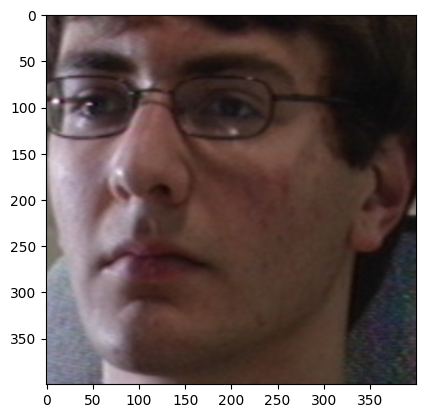

In [6]:
test_img_rgb = cv2.imread(os.path.join(DB_folder,"Test_DB","Images",test_fname))
ax = plt.subplot(1,1,1)
ax.imshow(test_img_rgb[:,:,::-1])
plt.show()

# Plot the authorized people (Images from Face_DB)

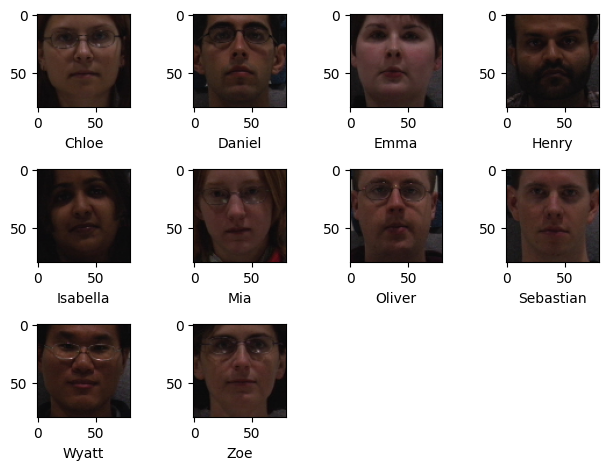

In [7]:
for pos,target in enumerate(target_names):
    target_img_rgb = cv2.imread(os.path.join(DB_folder, "Face_DB", "Images", target+"_000.jpg"))
    ax2 = plt.subplot(3,4,pos+1)
    ax2.set_xlabel(target)
    ax2.imshow(resizeImage(target_img_rgb,0.2)[:,:,::-1])
plt.tight_layout()
plt.show()

# How to load the landmarks and draw them in the image?

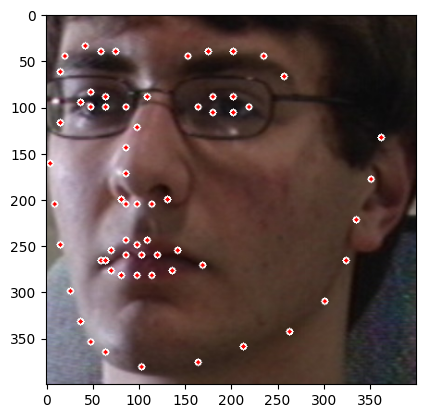

In [8]:
# Read the test image in color.
test_img_rgb = cv2.imread(os.path.join(DB_folder,"Test_DB","Images",test_fname))

# Obtain the name of its corresponding facial landmark data file (CSV)
csv_test = os.path.join(DB_folder,"Test_DB","Landmark_data","{}_{:03d}.csv".format(test_name,test_img_num))

# Load the landmark location data
landmarks_test= load_landmark_locations_csv(csv_test)

# Draw the landmarks
for landmark in landmarks_test:
    cv2.circle(test_img_rgb,landmark,4,(255,255,255),-1)
    cv2.circle(test_img_rgb, landmark, 2, (0, 0, 255), -1)
plt.imshow(test_img_rgb[:,:,::-1])
plt.show()

# Compute the similarity between the Test Image and the Authorized face images

In [9]:
# You may utilize any similarity function declared above. REMEMBER: The similarity ranges between [0,1]. 
# A similarity close to 1 means that the images are similar.

for target in target_names:
    target_img = cv2.imread(os.path.join(DB_folder, "Face_DB", "Images", target+"_000.jpg"), 0)
    similarity = cosineSimilarity_HOG(test_img,target_img)
    #similarity = cosineSimilarity_HOG_LBP(test_img,target_img)
    print("[Similarity] {} <-> {} : {:.4f}".format(test_name,target,similarity))

[Similarity] Caleb <-> Chloe : 0.6665
[Similarity] Caleb <-> Daniel : 0.6745
[Similarity] Caleb <-> Emma : 0.6690
[Similarity] Caleb <-> Henry : 0.7066
[Similarity] Caleb <-> Isabella : 0.6636
[Similarity] Caleb <-> Mia : 0.7332
[Similarity] Caleb <-> Oliver : 0.6652
[Similarity] Caleb <-> Sebastian : 0.7323
[Similarity] Caleb <-> Wyatt : 0.6339
[Similarity] Caleb <-> Zoe : 0.6615


# Compute the distance between the Test Image and the Authorized face images

In [10]:
# You may utilize any distance function declared above.REMEMBER: The distance ranges from 0 to +infinity. 
# The lesser values means that the images are more similar.

for target in target_names:
    # Load image from the Authorized DB
    target_img = cv2.imread(os.path.join(DB_folder, "Face_DB", "Images", target+"_000.jpg"), 0)
    
    # (Optional: Load landmark location data)
    csv_target = os.path.join(DB_folder,"Face_DB","Landmark_data","{}_{:03d}.csv".format(target,0))
    landmarks_target = load_landmark_locations_csv(csv_target)
    
    # Compute the distance
    dist = distance_featureMatching_SIFT(test_img,target_img)
    #dist = euclideanDistance_HOG(test_img,target_img)
    print("[Distance] {} <-> {} : {:.4f}".format(test_name,target,dist))

[Distance] Caleb <-> Chloe : 354.4466
[Distance] Caleb <-> Daniel : 370.4220
[Distance] Caleb <-> Emma : 384.9726
[Distance] Caleb <-> Henry : 363.9783
[Distance] Caleb <-> Isabella : 385.8264
[Distance] Caleb <-> Mia : 368.7089
[Distance] Caleb <-> Oliver : 346.0489
[Distance] Caleb <-> Sebastian : 395.3976
[Distance] Caleb <-> Wyatt : 342.5786
[Distance] Caleb <-> Zoe : 361.3568


# Plot feature matching

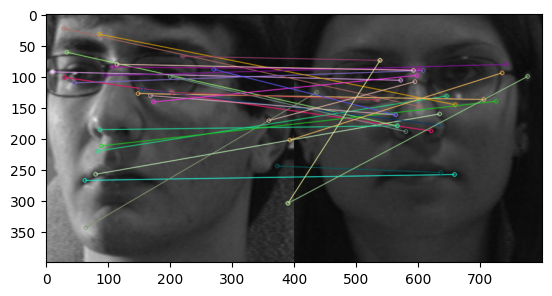

In [11]:
target = "Chloe"
target_img = cv2.imread(os.path.join(DB_folder, "Face_DB", "Images", target+"_000.jpg"), 0)
fig = draw_featureMatching_SIFT(test_img,target_img,sigma=1.6)
plt.imshow(fig)
plt.savefig("results_feature_matching.png",dpi=200.0,format="png")
plt.show()

As can be seen in the previous image, the Brute Force Feature Matching using SIFT for keypoint detection and feature extraction, is not very suitable for comparing two faces (even when the distance measure is acceptable).

# Performing feature matching using the landmarks as keypoints 

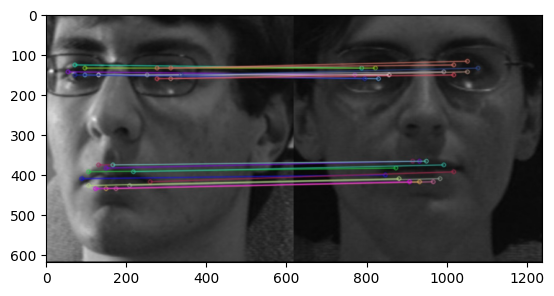

In [12]:
fig = cv2.imread("results_feature_matching_LM.jpg")
plt.imshow(fig)
plt.show()

HINT: Use the pointset_to_keypoints function. Use SIFT just for computing the descriptors.